# A deep Analysis in Netflix DataSet

The purpose of this analysis is to discover interesting things about the Series and movies inside the Netflix catalogue.

The dataset was downloaded from [here](https://www.kaggle.com/shivamb/netflix-shows)

In [1]:
#Import the neccesary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

In [2]:
#Read the dataset
netflix=pd.read_csv('Net.zip')

Once loaded the data, lets know our dataset a little better.

In [3]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


We have a total of 7787 entries or videos in our dataset. Taking this as a base we can say that there are columns with missing values. Som with more missing values than other columns.

Lets check the percentage of `Nan` Values for each column, if they exist.

In [4]:
for name in netflix.columns:
    na_values=netflix[name].isnull().sum()
    if na_values>0:
        percentage=round((na_values/7787)*100,2)
        print(name + ' column has {}%'.format(percentage))

director column has 30.68%
cast column has 9.22%
country column has 6.51%
date_added column has 0.13%
rating column has 0.09%


We can see that `director` and `cast` column has a lot of missing values. We can remove due they are not fundamental for our analysis.

Country is important, so let's fill the missing values with the most common value inside the column.

In [5]:
netflix['country'].value_counts().sort_values(ascending=False).head(20)

United States                    2555
India                             923
United Kingdom                    397
Japan                             226
South Korea                       183
Canada                            177
Spain                             134
France                            115
Egypt                             101
Turkey                            100
Mexico                            100
Australia                          83
Taiwan                             78
Brazil                             72
Philippines                        71
Nigeria                            70
Indonesia                          70
United Kingdom, United States      64
Germany                            61
United States, Canada              60
Name: country, dtype: int64

The most common value is United States, so lets fill Na Values with `United States`

In [6]:
#Sustitue the na values
netflix['country']=netflix['country'].fillna('United States')
#Check how many na values are left, 0 should be que answer.
print(netflix['country'].isnull().sum())

0


SUCCESS!!

As the `date_added` and `rating` column have almost none of missing values, we will repeat this process for every column.

In [7]:
date=netflix['date_added'].value_counts().sort_values(ascending=False).index[0]
netflix['date_added']=netflix['date_added'].fillna(date)
print(netflix['date_added'].isnull().sum())

0


In [8]:
rating=netflix['rating'].value_counts().sort_values(ascending=False).index[0]
netflix['rating']=netflix['rating'].fillna(rating)
print(netflix['rating'].isnull().sum())

0


Now lets remove the 2 column with the Nan values

In [9]:
netflix=netflix.drop(['director','cast'],axis=1)

In [10]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   country       7787 non-null   object
 4   date_added    7787 non-null   object
 5   release_year  7787 non-null   int64 
 6   rating        7787 non-null   object
 7   duration      7787 non-null   object
 8   listed_in     7787 non-null   object
 9   description   7787 non-null   object
dtypes: int64(1), object(9)
memory usage: 608.5+ KB


Now we can start working

We haven't seen the dataset yet, lets check how the values are stored:

In [11]:
netflix.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Data Cleaning

We can do some cleaning to make a better analysis, the things that we can do are:

- Just keep the year in `date_added` colum.
- The `duration` column contains two types of data, minutes if it is a movie, or Season if it is a Tv Show, we can separate these toew values into separate columns.
- In `listed_in` column says the category on which the TV Series o Movie is, but there are a lor of categories, we can try and leave a range of categories.

Let's start with the first one:

## Get the year from date_added column

In [12]:
#Convert to date type and then extract the year
netflix['date_added']=pd.to_datetime(netflix['date_added']).dt.year

## Cleaning the Duration column
Lets proceed with separating the duration for each category:

In [13]:
netflix['duration'].value_counts().head()

1 Season     1608
2 Seasons     382
3 Seasons     184
90 min        136
93 min        131
Name: duration, dtype: int64

There are only two ways a duration is stored, by Tv Show or by Movie.

The duration of a TV Show contains a number and then the word `Season`, and the movies contain the a number and the word `min`, let's use this to separate each value into different columns.

In [14]:
#Create a new column for each duration leaving only the numbers

#New column--------#Filter using boolean mask---------------------------------------#Take out strings-----------#Change type      
netflix['du_shows']=netflix.loc[netflix['duration'].str.contains('Season'),'duration'].str.replace(r'[A-Za-z]','').astype(float)
netflix['du_movies']=netflix.loc[netflix['duration'].str.contains('min'),'duration'].str.replace(r'[A-Za-z]','').astype(float)

## Cleaning the listed_in colum

Finally lets make some cleaning in the `listed_in` column

In [15]:
netflix['listed_in'].value_counts().head(20)

Documentaries                                        334
Stand-Up Comedy                                      321
Dramas, International Movies                         320
Comedies, Dramas, International Movies               243
Dramas, Independent Movies, International Movies     215
Kids' TV                                             205
Children & Family Movies                             177
Documentaries, International Movies                  172
Children & Family Movies, Comedies                   169
Comedies, International Movies                       161
Dramas, International Movies, Romantic Movies        153
Comedies, International Movies, Romantic Movies      139
Action & Adventure, Dramas, International Movies     117
Dramas                                               117
International TV Shows, TV Dramas                    111
Dramas, International Movies, Thrillers              109
Crime TV Shows, International TV Shows, TV Dramas    106
Comedies, Dramas, Independent M

Reading the categories, there are some words that could interfere in a good extraction, so lets remove them.

In [16]:
netflix['listed_in']=netflix['listed_in'].str.replace('International','').str.replace(",",'').str.replace('TV','').str.replace('Shows','').str.strip()
netflix['listed_in']=netflix['listed_in'].str.replace('British','').str.replace('Spanish','').str.replace('Language','').str.replace('Classic','')
netflix['listed_in']=netflix['listed_in'].str.replace('Movies','').str.replace('Cult','')

Lets now see how many unique values this column has:

In [17]:
netflix['listed_in'].unique().shape

(443,)

Judging the amount of unique values there are, to know how every categorie is sotores and their differences is gonna be a very overwealming job that with a mor understanding of the dataset could be possible, but this project has not that scope, so the realistic way to get at leats one categorie per Movie/Serie is going to be to exctract the first word of for every Movie/Serie inside the `listed_in` column which may represent the main topic of the Movio/Serie.

So lets do this, lets first see how the categories will be extracting the first word:

In [18]:
test_1=netflix['listed_in']
test_1=test_1.str.extract(r'\b(\w+)\b')
print(test_1.value_counts())
print(test_1.value_counts().sum())

Dramas           1707
Comedies         1314
Action            801
Documentaries     764
Children          502
Crime             414
Kids              389
Stand             367
Horror            279
Docuseries        262
Romantic          253
Reality           188
Anime             167
Thrillers         109
Korean            107
Music              33
Sci                26
Independent        22
LGBTQ               4
Mysteries           2
Sports              2
dtype: int64
7712


The output look good, from 461 unique values to 23 is a very good step. Also lets notice that we were form 7787 values to 7714, we lost 73 values due the last cleaning, but the word removed really did not say anithing about a categorie, so they removal is not significant.

Some categories need a second categorie in order to know more about the Movie/Series, such is the case like Drama, we may have `Drama-Comedies`, `Drama-Crime`, `Drama-Action`, etc. If we were to have a full list of different and exact categories we may need to know how exactly were stored these values in the dataset. We previously said that this is not the scope of this project, having a `Drama` categorie may be too general if we want to give the most aquarancy we can.

So lets do another test of what it we remove `Drama` from the categories in order to hace the second Categorie:

In [19]:
test_2=netflix['listed_in']
test_2=test_2.str.replace('Dramas','')
test_2=test_2.str.extract(r'\b(\w+)\b')
print(test_2.value_counts())
print(test_2.value_counts().sum())

Comedies         1314
Action            801
Documentaries     764
Children          502
Romantic          455
Independent       420
Crime             414
Kids              389
Stand             367
Thrillers         304
Horror            303
Docuseries        262
Reality           188
Anime             167
Korean            107
Music              97
Sci                64
Sports             46
Mysteries          31
Faith              29
LGBTQ              25
Teen               17
dtype: int64
7066


We can see now that the remain data is 7022, that is a loss of 615 more values having a total of 688 lost values.

LEts now see what we have gained. We can see that the categories having very low amount of movies, now they increased in number, and adding new categorie called `Teen`. 

It may be a huge loss of information, but if we remove the word `Drama` and then it was deleted all tyoe of information, that means that those Movies/Series were stores only with the categorie `Drama` So we can fill those missing values with it and don not have such a loss.

You may ask, but what about the first 73 values that were deleted since the beginninig, will you fill those values with `Drama`?

Well those Movies/Series did not have a good categorie since the beggining, and they represent less that 1% of the data, and how `Drama` was the most common value...then yes.

So at the end we distribute more than 1000 values from the `Drama` categorie into a more accurate one and leave the purest `Drama` category into the Movie/Series that deserve it.

Now lets put all of that together inside our DataFrame

In [20]:
netflix['listed_in']=netflix['listed_in'].str.replace('Dramas','')
netflix['listed_in']=netflix['listed_in'].str.extract(r'\b(\w+)\b')
netflix['listed_in']=netflix['listed_in'].fillna('Drama')
print(netflix['listed_in'].value_counts())

Comedies         1314
Action            801
Documentaries     764
Drama             721
Children          502
Romantic          455
Independent       420
Crime             414
Kids              389
Stand             367
Thrillers         304
Horror            303
Docuseries        262
Reality           188
Anime             167
Korean            107
Music              97
Sci                64
Sports             46
Mysteries          31
Faith              29
LGBTQ              25
Teen               17
Name: listed_in, dtype: int64


Lets take a look into aur DataSet:

In [21]:
netflix.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,du_shows,du_movies
0,s1,TV Show,3%,Brazil,2020,2020,TV-MA,4 Seasons,Sci,In a future where the elite inhabit an island ...,4.0,NaN
1,s2,Movie,7:19,Mexico,2016,2016,TV-MA,93 min,Drama,After a devastating earthquake hits Mexico Cit...,NaN,93.0
2,s3,Movie,23:59,Singapore,2018,2011,R,78 min,Horror,"When an army recruit is found dead, his fellow...",NaN,78.0
3,s4,Movie,9,United States,2017,2009,PG-13,80 min,Action,"In a postapocalyptic world, rag-doll robots hi...",NaN,80.0
4,s5,Movie,21,United States,2020,2008,PG-13,123 min,Drama,A brilliant group of students become card-coun...,NaN,123.0


In [22]:
netflix.iloc[1089,5]=2008

We are now ready to analyze!!
## Analysis

In [23]:
print(netflix['type'].value_counts())
print(netflix.shape[0])


Movie      5377
TV Show    2410
Name: type, dtype: int64
7787


From Netflix we only have 2 categories according the dataset:

- Movies
- TV Shows or Serie

We have a total of 7,787 thing to watch, and from that amount the 75% are movies and 25% are Series.

In [24]:
netflix['listed_in'].value_counts().sort_values(ascending=False).head(8)

Comedies         1314
Action            801
Documentaries     764
Drama             721
Children          502
Romantic          455
Independent       420
Crime             414
Name: listed_in, dtype: int64

The most common thing we can find in netflix are Comedies, Action and Documentaries for both types: TV Shows and Series.

Lets separate the DataSet in by the Type:

In [25]:
Shows=netflix[netflix['type']=='TV Show']
Movies=netflix[netflix['type']=='Movie']

## Series
Let's see how many Seasons the TV Series have:

In [26]:
Shows['du_shows'].value_counts()

1.0     1608
2.0      382
3.0      184
4.0       87
5.0       58
6.0       30
7.0       19
8.0       18
9.0        8
10.0       6
11.0       3
15.0       2
12.0       2
13.0       2
16.0       1
Name: du_shows, dtype: int64

Most of the Series that are in Netflix have between 1 to 3 season, but there a few more that are around 4 to 8 seasons, and unimmaginable there are Series that have more than 8 'til 16 seasons.

In [27]:
# seasons1=netflix[netflix['du_shows']>8]
# seasons=seasons1.groupby('listed_in').mean().sort_values(by='listed_in')
Shows.groupby('listed_in').mean().sort_values(by='du_shows',ascending=False)

,date_added,release_year,du_shows,du_movies
listed_in,,,,
Action,2018.825000,2016.262500,2.700000,NaN
Comedies,2018.582222,2015.795556,2.622222,NaN
Teen,2018.647059,2017.058824,2.352941,NaN
Sci,2019.000000,2014.470588,2.117647,NaN
Kids,2018.516710,2015.678663,1.969152,NaN
Stand,2018.108696,2017.630435,1.869565,NaN
Horror,2018.617021,2017.680851,1.829787,NaN
Crime,2018.548309,2017.405797,1.760870,NaN
Thrillers,2018.071429,2017.642857,1.642857,NaN


The medium of seasons each categoria has in netflix are the following:

For almost every categorie, the mean seasons for each category are from 1 to 2 except:
- Sci
- Teen
- Comedies
- Action

That have a mean of 2-3 Seasons


## Time

In [28]:
Shows['Time']=Shows['date_added']-Shows['release_year']

<ipython-input-28-912f90dd5a12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Shows['Time']=Shows['date_added']-Shows['release_year']


In [29]:
Shows.value_counts('date_added').sort_values()

date_added
2008      1
2013      5
2014      6
2021     29
2015     30
2016    185
2017    361
2018    430
2019    656
2020    707
dtype: int64

There are movies in Netflix that were made a long time ago, but for the purpose of this analisis we eill only take years starting from 2007, which is the year when Netflix started their Streaming services. So the difference must be at the most 13 years 'cus we are in 2021.

Lets see the mean time that it takes to bring a new Series into Netflix


## Original vs Non Orignial Series

To know Which are Original Series we only need to know the difference between the date_added and the released_year, it should be 0. Comparar las originales vs las no originales en la misma tabla.

In [30]:
x=Shows[(Shows['Time']<14)&(Shows['Time']!=0)]
x['Time'].mean()

3.3151298119964188

Series that are not Original from Netflix take 3 years (*mean*) to be up loaded to Netflix.

<function matplotlib.pyplot.show(close=None, block=None)>

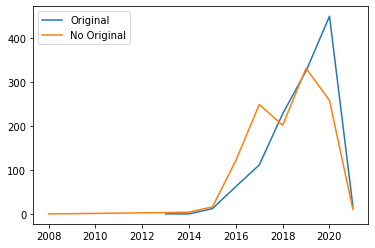

In [31]:
y=Shows[Shows['Time']==0]
y=y.groupby('date_added').count()
x=Shows[Shows['Time']!=0]
x=x.groupby('date_added').count()
plt.plot(y.index,y['Time'],label='Original')
plt.plot(x.index,x['Time'],label='No Original')
plt.legend()
plt.show

We can see that the Original Series started to appear not until 5 years later since the Streaming service in 2013.

Also Original Series surpassed the amount of Non Original Series in some moment of 2017 being this type of Series the more common in  Netflix now.

In [32]:
Shows[Shows['date_added']==2008]

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,du_shows,du_movies,Time
1765,s1766,TV Show,Dinner for Five,United States,2008,2007,TV-MA,1 Season,Stand,"In each episode, four celebrities join host Jo...",1.0,NaN,1


This is the oldest Series in Netflix that stills active, added in 2008 called `Dinner for Five`.

In [33]:
Shows[(Shows['Time']==0)&(Shows['date_added']==2013)]

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,du_shows,du_movies,Time
5312,s5313,TV Show,Russell Peters vs. the World,United States,2013,2013,NR,1 Season,Docuseries,"A four-part docu-series that's an exclusive, b...",1.0,NaN,0


The First Netflix orignal Series was `Russell Peters vs. the World` that us a Docuserie with 1 Season

# Movies

Let's analyze the movies now, first a new column called `Time` will be added being the extraction of the `date_added` column and the `release_year` column

In [34]:
Movies['Time']=Movies['date_added']-Movies['release_year']

<ipython-input-34-07c7857ba3eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Movies['Time']=Movies['date_added']-Movies['release_year']


In [35]:
Movies.head()

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,du_shows,du_movies,Time
1,s2,Movie,7:19,Mexico,2016,2016,TV-MA,93 min,Drama,After a devastating earthquake hits Mexico Cit...,NaN,93.0,0
2,s3,Movie,23:59,Singapore,2018,2011,R,78 min,Horror,"When an army recruit is found dead, his fellow...",NaN,78.0,7
3,s4,Movie,9,United States,2017,2009,PG-13,80 min,Action,"In a postapocalyptic world, rag-doll robots hi...",NaN,80.0,8
4,s5,Movie,21,United States,2020,2008,PG-13,123 min,Drama,A brilliant group of students become card-coun...,NaN,123.0,12
6,s7,Movie,122,Egypt,2020,2019,TV-MA,95 min,Horror,"After an awful accident, a couple admitted to ...",NaN,95.0,1


Lets see from where the movies are made

In [36]:
Movies['country'].value_counts().sort_values(ascending=False).head()

United States     2080
India              852
United Kingdom     193
Canada             118
Spain               89
Name: country, dtype: int64

Is obvious that United Satates is the Country that produces more movies, the second country that has more movies is India followed by United Kingdom, Cadan ans Spain, but the last three are much more less that India. Looks like India has a powerful movie industry as well.

In [37]:
No_originals=Movies[Movies['Time']!=0]
M_originlas=Movies[Movies['Time']==0]

In [38]:
No_originals.loc[No_originals['Time']<14,'Time'].mean()

3.9749437841310633

The mean time for a movie to be upleaded to Netflix is 4 years.

<AxesSubplot:xlabel='listed_in'>

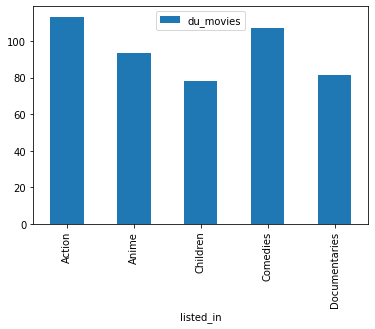

In [39]:
pv_1=Movies.pivot_table(index='listed_in',values='du_movies',aggfunc=np.mean)
pv_1.sort_values(ascending=False,by='du_movies')
pv_1.head().plot(kind='bar')

The top 5 genre duration movies are:
- Action
- Comedies
- Anime
- Documentaries
- Children

So if you want to watch a quick movie, these are the genres that you have to avoid.

## Oldest movies added in Netflix

Now Lets check the minum year when a movie was added in order to see the oldest added movies in NEtflix.

In [40]:
print(M_originlas['date_added'].min())
print(No_originals['date_added'].min())

2009
2008


In [41]:
M_originlas[M_originlas['date_added']==2009]

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,du_shows,du_movies,Time
5765,s5766,Movie,Splatter,United States,2009,2009,TV-MA,29 min,Horror,"After committing suicide, a washed-up rocker r...",NaN,29.0,0


The firts original movie, according to this DataSet to be uploaded to Netflix was `Splatter` in 2009, just is 29 minutes long and is a Horror movie.

In [42]:
No_originals[No_originals['date_added']==2008]

,show_id,type,title,country,date_added,release_year,rating,duration,listed_in,description,du_shows,du_movies,Time
7113,s7114,Movie,To and From New York,United States,2008,2006,TV-MA,81 min,Independent,"While covering a story in New York City, a Sea...",NaN,81.0,2


The first movie, according this DataSet to be upleaded to Netflix, and stills current is `To and From New York`, is an Independent movie.

It would be interesting to know how the Original movies have being developed in the years vs the no Originals ones.

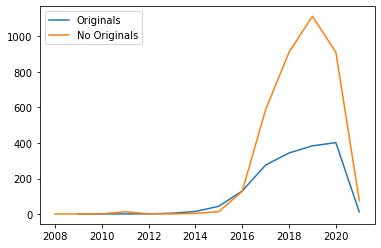

In [43]:
pv_originals=M_originlas.pivot_table(index='date_added',values='Time',aggfunc='count')
pv_no_originals=No_originals.pivot_table(index='date_added',values='Time',aggfunc='count')

plt.plot(pv_originals.index,pv_originals['Time'],label='Originals')
plt.plot(pv_no_originals.index,pv_no_originals['Time'],label='No Originals')
plt.legend()
plt.show()

The first years there wa no difference between the amount of Originals and no Originals movies, in 2014 the Original movies were more than the other movies. Starting 2016 No Original movies started to be majority in Netflix.

## Movies through the years according genre

Now lets see how many movies were uploeaded to netflix within the years according their genre, to do a esthetic analysisis only the top 5 categories will be analyzed here:

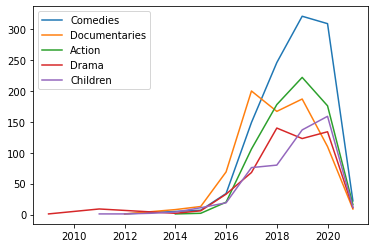

In [44]:
genres=Movies['listed_in'].value_counts().sort_values(ascending=False).head(5).index
for g in genres:
    table_genre=Movies[Movies['listed_in']==g]
    pv_genre=table_genre.pivot_table(index='date_added',values='listed_in',aggfunc='count')
    plt.plot(pv_genre.index,pv_genre['listed_in'],label=g)
plt.legend()
plt.show()

We can see that in the first years there was no really a genre that ruled over the other ones, then in 2015 the `Docuseries` were the ones to take the car, but finally the `Comedy` movies arrived to stay being the top genre in Netflix since then. So we can expect to have more Comedy movies in teh catalogue. Action movies were the 2nd genre  with more uploaded frquency.

Surprissingly in 2020 the uploaded of many genres dropped, and the only one to rise was the Children category, this may be because Covid, kids staying in house made the thing hard for dads, so the amount of views for this category increased, that coul lead to a major Children content to be uploaded.

## Movies vs Series

Finally lets check hoe movies vs Series behave over the years

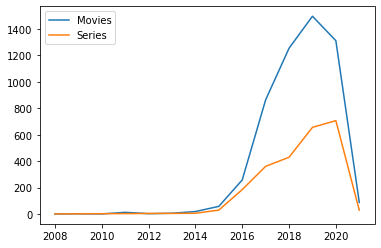

In [45]:
vs1=Movies.pivot_table(index='date_added',values='type',aggfunc='count')
vs2=Shows.pivot_table(index='date_added',values='type',aggfunc='count')
plt.plot(vs1.index,vs1['type'],label='Movies')
plt.plot(vs2.index,vs2['type'],label='Series')
plt.legend()
plt.show()